In [ ]:
%%capture
!pip install super-gradients==3.1.0
!pip install imutils
!pip install roboflow
!pip install pytube --upgrade

In [ ]:
from super_gradients.training import Trainer
from super_gradients.training import dataloaders
from super_gradients.training.dataloaders.dataloaders import coco_detection_yolo_format_train,coco_detection_yolo_format_val

The console stream is logged into /root/sg_logs/console.log


[2023-06-05 05:27:00] INFO - crash_tips_setup.py - Crash tips is enabled. You can set your environment variable to CRASH_HANDLER=FALSE to disable it
/usr/local/lib/python3.10/dist-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
[2023-06-05 05:27:06] WARNING - __init__.py - Failed to import pytorch_quantization
[2023-06-05 05:27:06] WARNING - calibrator.py - Failed to import pytorch_quantization
[2023-06-05 05:27:06] WARNING - export.py - Failed to import pytorch_quantization
[2023-06-05 05:27:06] WARNING - selective_quantization_utils.py - Failed to import pytorch_quantization


In [ ]:
from IPython.display import clear_output



In [ ]:
from super_gradients.training.losses import PPYoloELoss
from super_gradients.training.metrics import DetectionMetrics_050
from super_gradients.training.models.detection_models.pp_yolo_e import PPYoloEPostPredictionCallback

In [ ]:

from super_gradients.training import models


In [ ]:
CHECKPOINT_DIR = 'checkpoints2'
trainer = Trainer(experiment_name='ppe_yolonas_run2', ckpt_root_dir=CHECKPOINT_DIR)


In [ ]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="IuYv6KOKs5p62rFSLvGa")
project = rf.workspace("objet-detect-yolov5").project("eep_detection-u9bbd")
dataset = project.version(1).download("yolov5")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to EEP_Detection-1 in yolov5pytorch:: 100%|██████████| 6482/6482 [00:00<00:00, 6645.35it/s]


In [ ]:
dataset_params = {
    'data_dir':'/content/EEP_Detection-1',
    'train_images_dir':'train/images',
    'train_labels_dir':'train/labels',
    'val_images_dir':'valid/images',
    'val_labels_dir':'valid/labels',
    'test_images_dir':'test/images',
    'test_labels_dir':'test/labels',
    'classes': ['Protective Helmet', 'Shield', 'Jacket', 'Dust Mask', 'Eye Wear', 'Glove', 'Protective Boots']
}

In [ ]:
train_data = coco_detection_yolo_format_train(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['train_images_dir'],
        'labels_dir': dataset_params['train_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size':16,
        'num_workers':2
    }
)

val_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['val_images_dir'],
        'labels_dir': dataset_params['val_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size':16,
        'num_workers':2
    }
)

test_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['test_images_dir'],
        'labels_dir': dataset_params['test_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size':16,
        'num_workers':2
    }
)

clear_output()

In [ ]:
model = models.get('yolo_nas_s', 
                   num_classes=len(dataset_params['classes']), 
                   pretrained_weights="coco"
                   )

[2023-06-05 01:18:09] INFO - checkpoint_utils.py - License Notification: YOLO-NAS pre-trained weights are subjected to the specific license terms and conditions detailed in 
https://github.com/Deci-AI/super-gradients/blob/master/LICENSE.YOLONAS.md
By downloading the pre-trained weight files you agree to comply with these terms.


  0%|          | 0.00/73.1M [00:00<?, ?B/s]

Downloading: "https://sghub.deci.ai/models/yolo_nas_s_coco.pth" to /root/.cache/torch/hub/checkpoints/yolo_nas_s_coco.pth


In [ ]:

train_params = {
    # ENABLING SILENT MODE
    'silent_mode': True,
    "average_best_models":True,
    "warmup_mode": "linear_epoch_step",
    "warmup_initial_lr": 1e-6,
    "lr_warmup_epochs": 3,
    "initial_lr": 1e-3,
    "lr_mode": "cosine",
    "cosine_final_lr_ratio": 0.1,
    "optimizer": "Adam",
    "optimizer_params": {"weight_decay": 0.0001},
    "zero_weight_decay_on_bias_and_bn": True,
    "ema": True,
    "ema_params": {"decay": 0.9, "decay_type": "threshold"},
    "max_epochs": 20,
    "mixed_precision": True,
    "loss": PPYoloELoss(
        use_static_assigner=False,
        # NOTE: num_classes needs to be defined here
        num_classes=len(dataset_params['classes']),
        reg_max=16
    ),
    "valid_metrics_list": [
        DetectionMetrics_050(
            score_thres=0.1,
            top_k_predictions=300,
            # NOTE: num_classes needs to be defined here
            num_cls=len(dataset_params['classes']),
            normalize_targets=True,
            post_prediction_callback=PPYoloEPostPredictionCallback(
                score_threshold=0.01,
                nms_top_k=1000,
                max_predictions=300,
                nms_threshold=0.7
            )
        )
    ],
    "metric_to_watch": 'mAP@0.50'
}

In [ ]:
trainer.train(model=model, 
              training_params=train_params, 
              train_loader=train_data, 
              valid_loader=val_data)


[2023-06-05 02:33:09] INFO - sg_trainer.py - Using EMA with params {'decay': 0.9, 'decay_type': 'threshold'}


The console stream is now moved to checkpoints2/ppe_yolonas_run2/console_Jun05_02_33_09.txt


[2023-06-05 02:33:15] INFO - sg_trainer_utils.py - TRAINING PARAMETERS:
    - Mode:                         Single GPU
    - Number of GPUs:               1          (1 available on the machine)
    - Dataset size:                 2264       (len(train_set))
    - Batch size per GPU:           16         (batch_size)
    - Batch Accumulate:             1          (batch_accumulate)
    - Total batch size:             16         (num_gpus * batch_size)
    - Effective Batch size:         16         (num_gpus * batch_size * batch_accumulate)
    - Iterations per epoch:         141        (len(train_loader))
    - Gradient updates per epoch:   141        (len(train_loader) / batch_accumulate)

[2023-06-05 02:36:04] INFO - base_sg_logger.py - Checkpoint saved in checkpoints2/ppe_yolonas_run2/ckpt_best.pth
[2023-06-05 02:36:04] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.8049760460853577
[2023-06-05 02:47:23] INFO - sg_trainer.py - RUNNING ADDITIONAL TEST ON THE

In [ ]:
best_model = models.get('yolo_nas_s',
                        num_classes=len(dataset_params['classes']),
                        checkpoint_path="checkpoints2/ppe_yolonas_run2/ckpt_best.pth")

[2023-06-05 05:27:47] INFO - checkpoint_utils.py - Successfully loaded model weights from checkpoints2/ppe_yolonas_run2/ckpt_best.pth EMA checkpoint.


In [ ]:
trainer.test(model=best_model,
            test_loader=test_data,
            test_metrics_list=DetectionMetrics_050(score_thres=0.1, 
                                                   top_k_predictions=300, 
                                                   num_cls=len(dataset_params['classes']), 
                                                   normalize_targets=True, 
                                                   post_prediction_callback=PPYoloEPostPredictionCallback(score_threshold=0.01, 
                                                                                                          nms_top_k=1000, 
                                                                                                          max_predictions=300,                                                                              
                                                                                                          nms_threshold=0.7)
                                                  ))

Test: 100%|██████████| 21/21 [00:08<00:00,  2.44it/s]


{'Precision@0.50': tensor(0.0695),
 'Recall@0.50': tensor(0.9627),
 'mAP@0.50': tensor(0.8236),
 'F1@0.50': tensor(0.1267)}

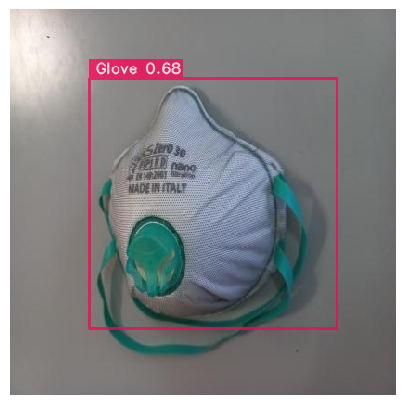

In [ ]:
img_url = '/content/EEP_Detection-1/test/images/20220721_162036_jpg.rf.f6b8fdbdef55ce36cd4ad61549b2c1e2.jpg'
best_model.predict(img_url).show()

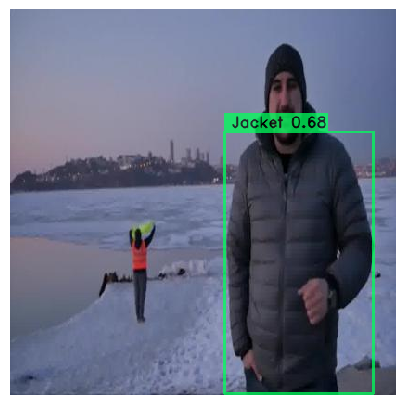

In [ ]:
img_url = '/content/EEP_Detection-1/test/images/AightOne0641_jpg.rf.4ebe50401d7d6d67f6c957af74742493.jpg'
best_model.predict(img_url).show()

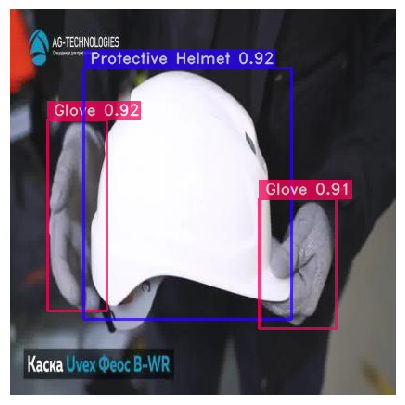

In [ ]:
img_url = '/content/EEP_Detection-1/test/images/SikctinTwo0154_jpg.rf.2c19039c265d41c582b4cda4ad07306f.jpg'
best_model.predict(img_url).show()

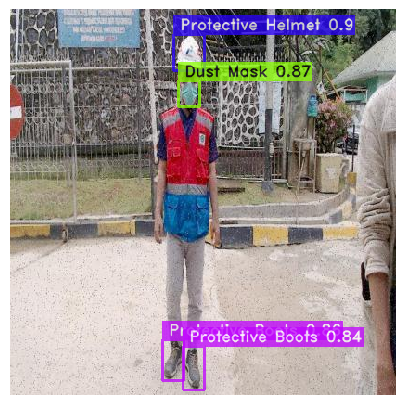

In [ ]:
img_url = '/content/EEP_Detection-1/test/images/image_10_jpg.rf.8190931340569a39e12590f0069d7fa3.jpg'
best_model.predict(img_url).show()

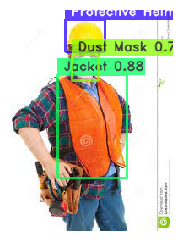

In [ ]:
img_url = '/content/1.jpeg'
best_model.predict(img_url).show()


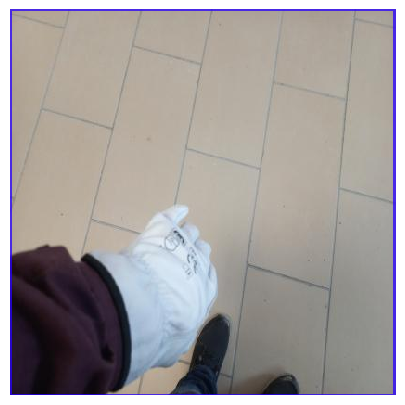

In [ ]:
img_url = '/content/EEP_Detection-1/valid/images/20220721_161927_jpg.rf.56b8fd236d16af66703544bae6fb6d14.jpg'
best_model.predict(img_url).show()

In [ ]:
input_video_path = f"/content/demo.mp4"
output_video_path = "detections.mp4"

In [ ]:
import torch
device = 'cuda' if torch.cuda.is_available() else "cpu"

In [ ]:
# best_model.to(device).predict(input_video_path).save(output_video_path)